# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math
import nltk

import spacy
import numpy as np
import pandas as pd

import re
import string

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from lightgbm import LGBMClassifier
from tqdm.auto import tqdm

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


## EDA

Let's check the number of movies and reviews over years.

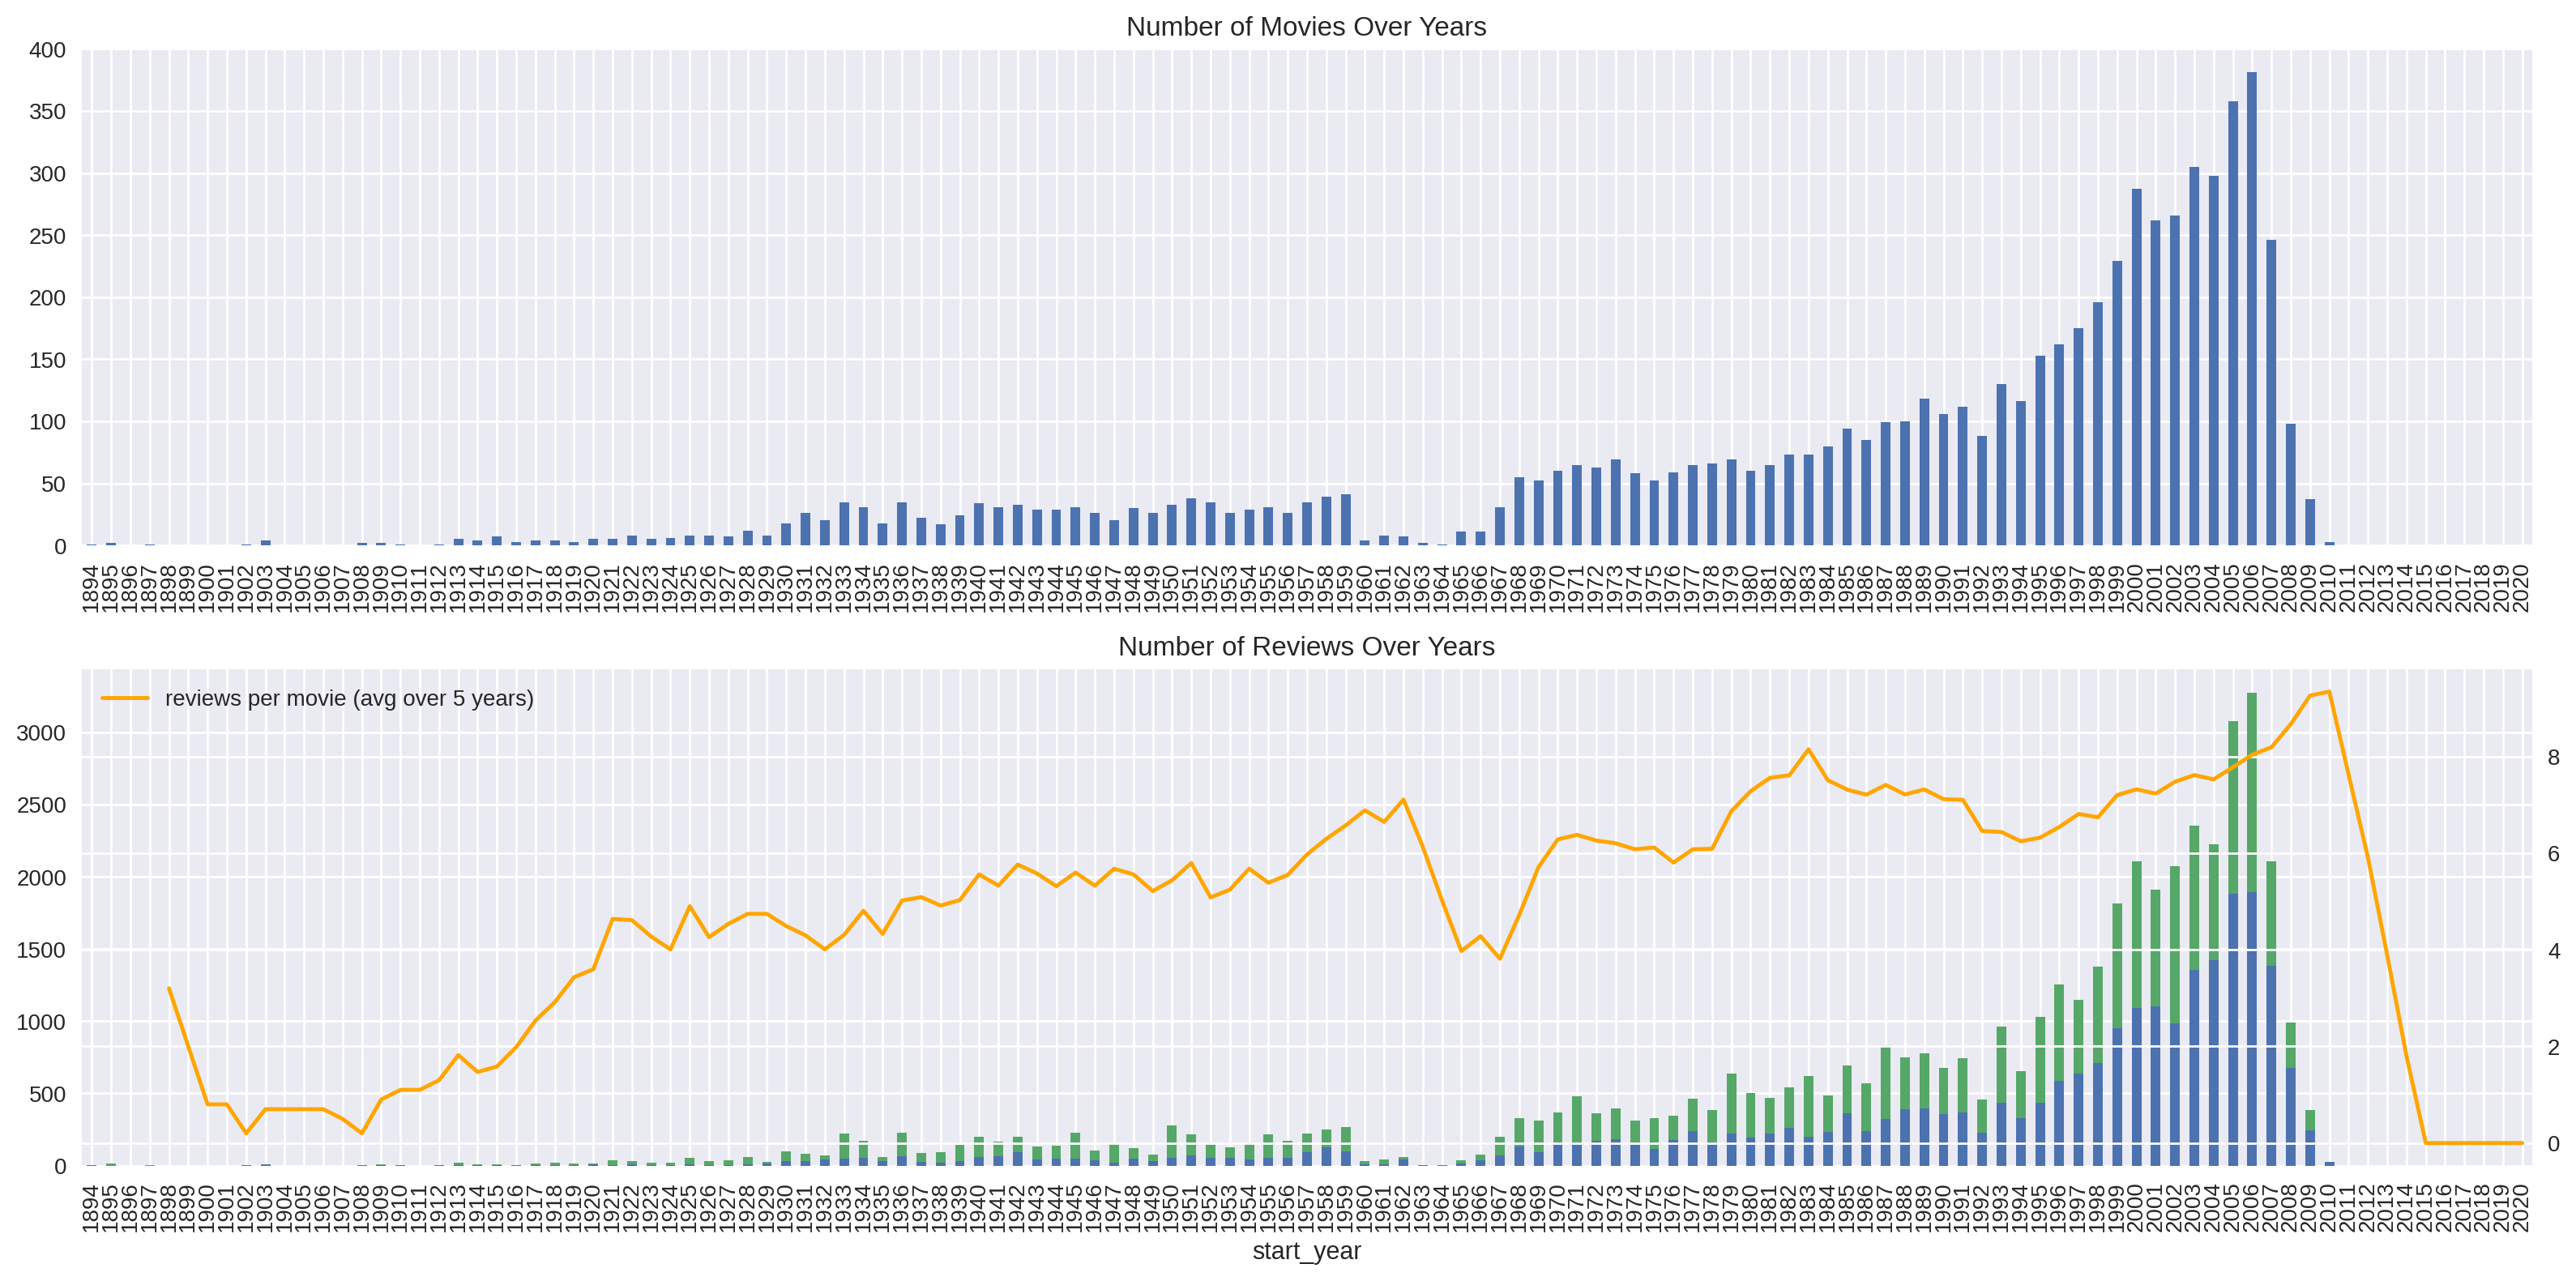

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

**Number of Movies Over Years**  

**Increasing Trend**: The number of movies released each year has shown a consistent increase over time.  
**Significant Spike**: There is a noticeable spike in the number of movies released in recent years, indicating a surge in movie production.  

**Number of Reviews Over Years**  

**Total Reviews**: The total number of reviews per year has also shown an increasing trend, similar to the number of movies released.  

**Reviews per Movie**: The number of reviews per movie, depicted by the orange line, fluctuates over time but generally follows an upward trend.  

**Insights**  

**Correlation**: There appears to be a correlation between the number of movies released and the number of reviews received. As more movies are produced, the total number of reviews also increases.  

**Audience Engagement**: The increasing number of reviews per movie suggests growing audience engagement and interest in providing feedback on movies.  

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

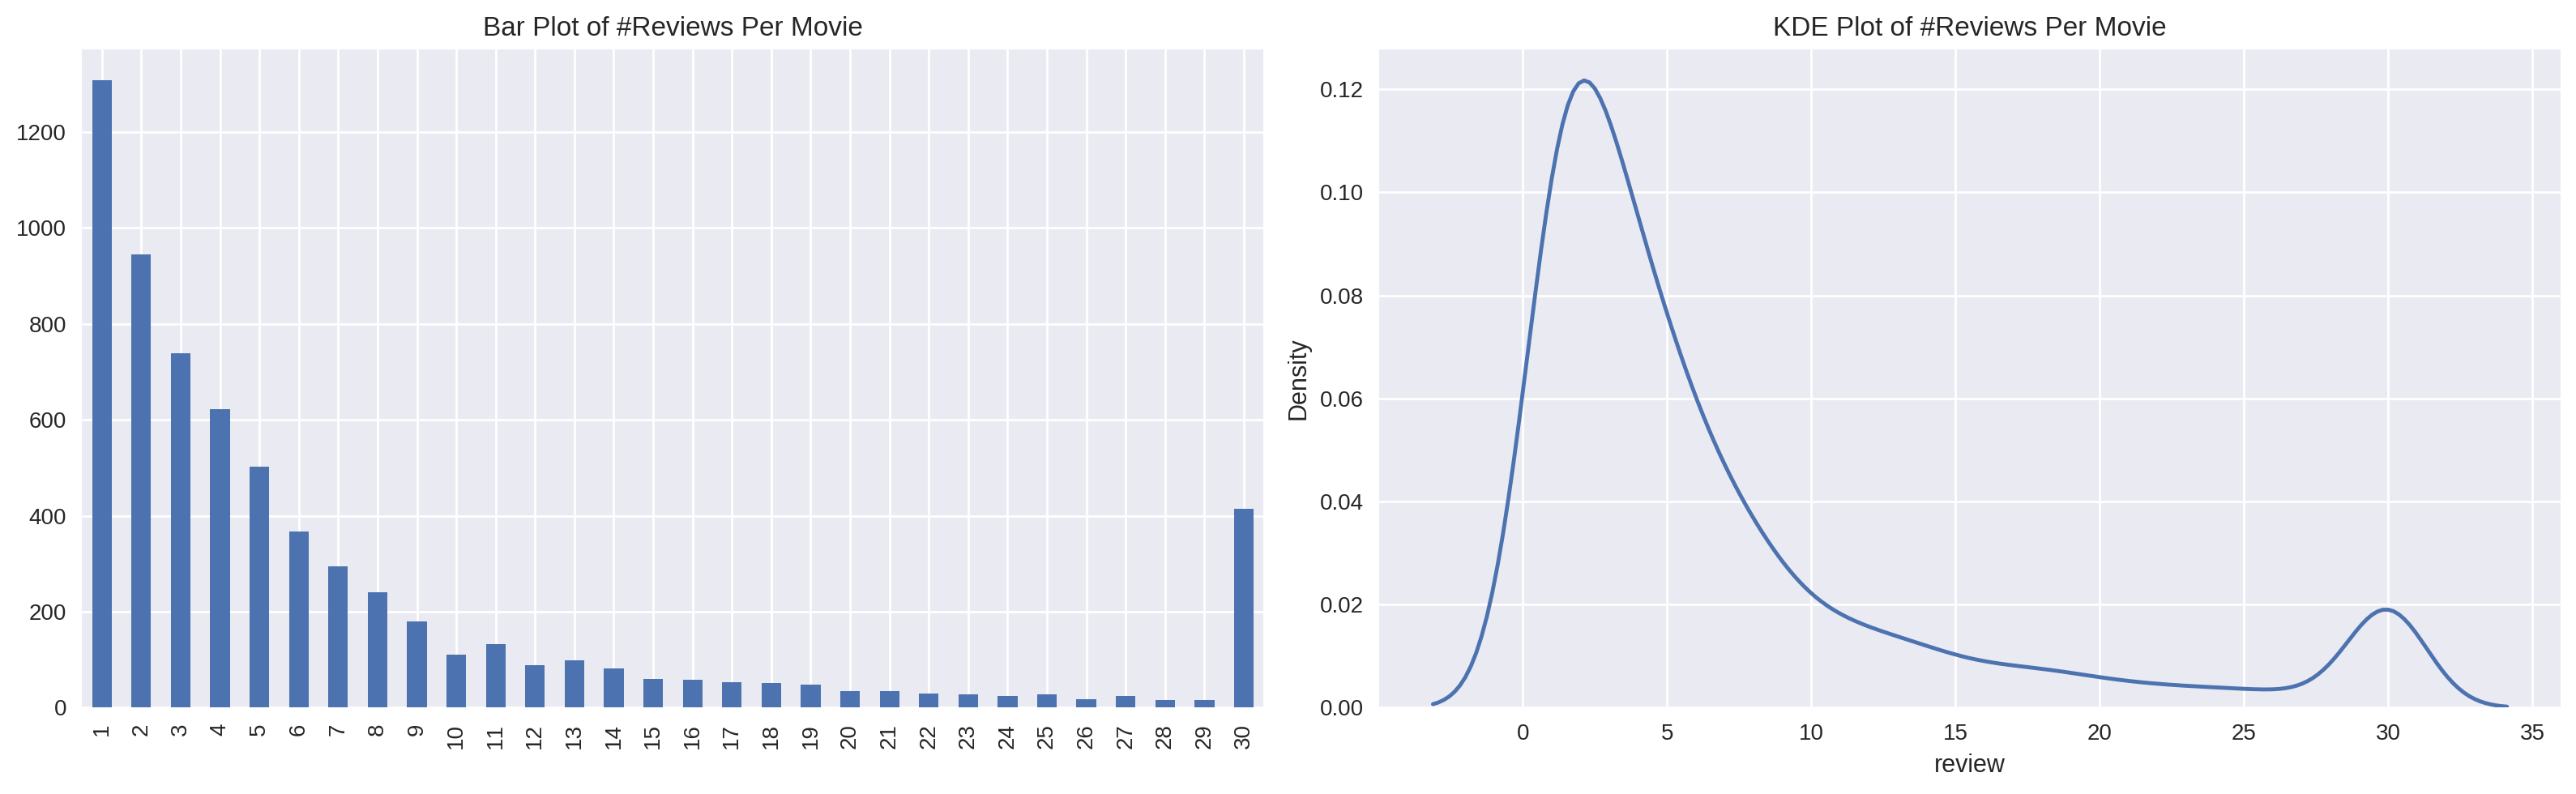

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

# Bar Plot of Reviews Per Movie
**Distribution**:   
The bar plot shows that most movies receive a low number of reviews, with the frequency decreasing as the number of reviews increases.
**Concentration**:  
The highest concentration of movies falls within the 0-5 reviews range, indicating that a majority of movies do not receive extensive reviews.  

# KDE Plot of Reviews Per Movie

**Density Peak**: The Kernel Density Estimate (KDE) plot highlights a prominent peak around 2-3 reviews per movie, suggesting that this is the most common range for the number of reviews.  

**Distribution Shape**: The density gradually decreases as the number of reviews increases, reinforcing the observation from the bar plot that fewer movies receive a higher number of reviews.  

**Insights**  
Review Patterns: Both plots indicate that the majority of movies receive only a few reviews, with a significant drop-off as the number of reviews increases.
Audience Engagement: The concentration of reviews around the lower end suggests that while many movies are released, only a few manage to capture significant audience attention and engagement.

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

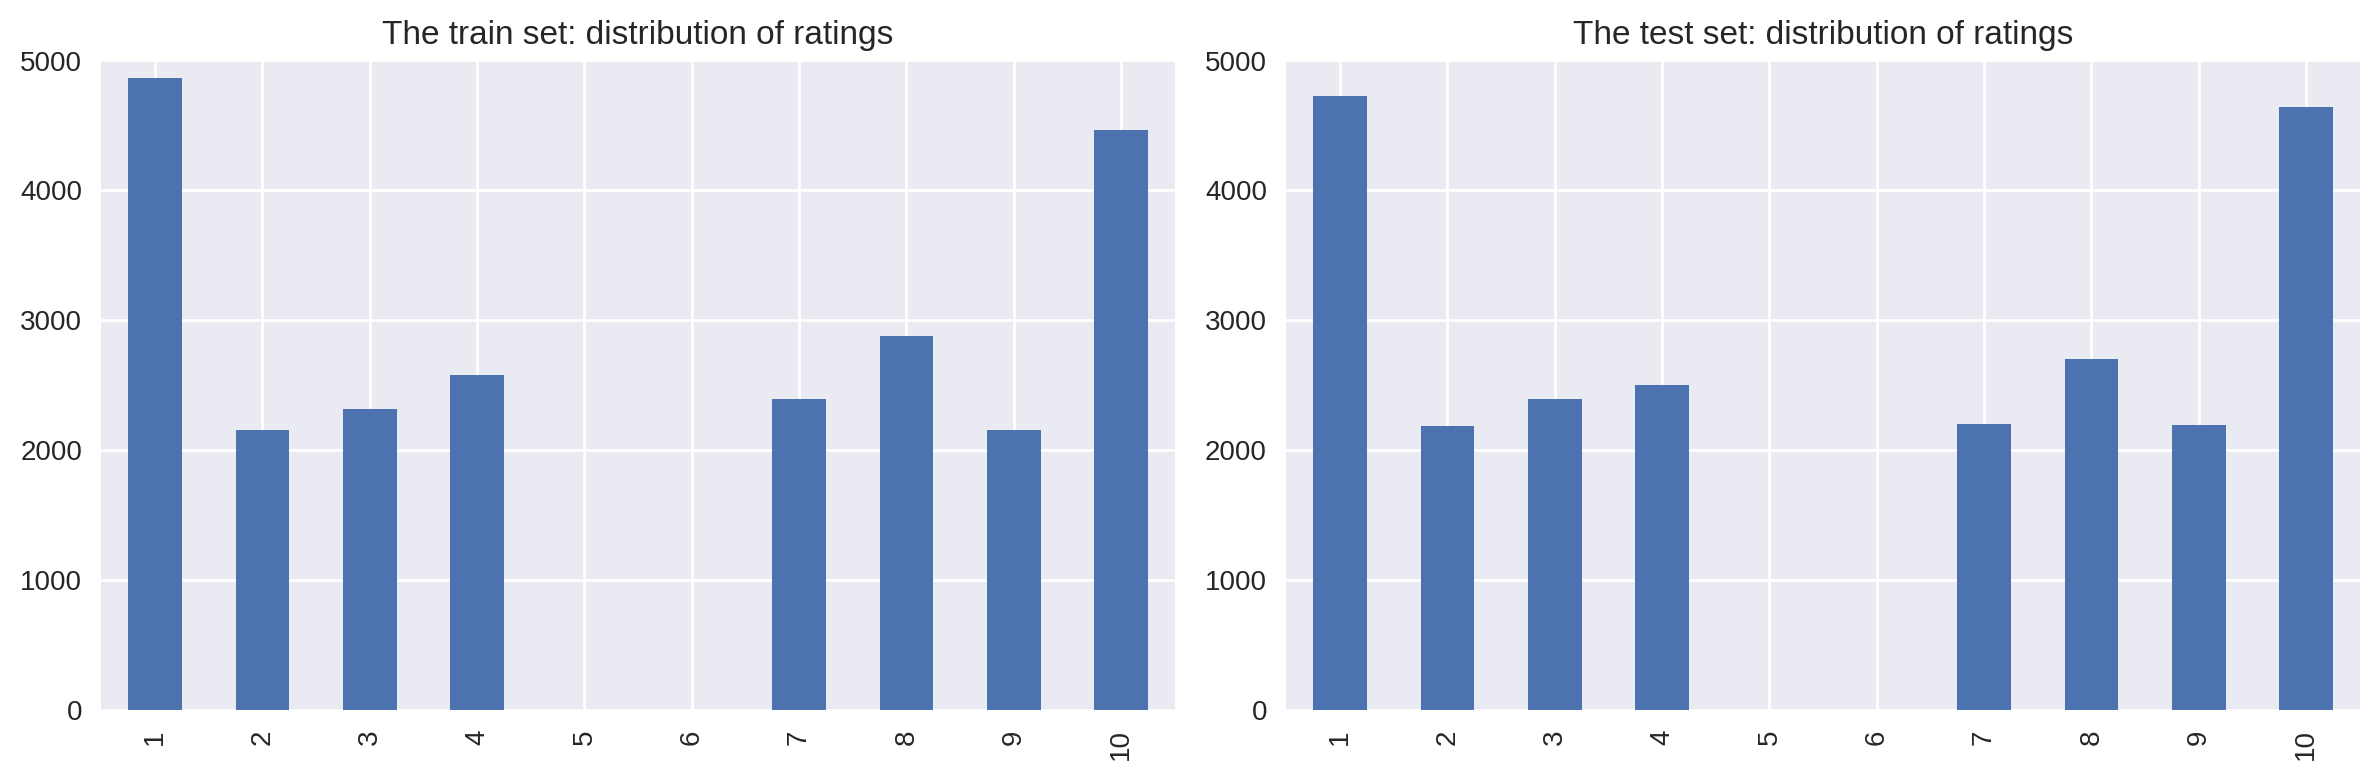

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

# Distribution of Ratings in Train and Test Sets

**Overall Distribution**:  
Both the training and test sets show a similar distribution of ratings.  
The ratings range from 1 to 10 in both sets.  

**Frequency of Ratings**:  
Lower Ratings (1-4): These ratings have a lower frequency in both the training and test sets.  
Higher Ratings (7-10): These ratings are more common and have a higher frequency in both sets.  

**Peak Frequencies**:
The highest frequency of ratings appears to be around 8 and 9 in both the training and test sets.  
The frequency of ratings decreases as we move towards the extremes (1 and 10).  

**Consistency**:  
The distribution of ratings is consistent between the training and test sets, indicating that the data is well-balanced.  

**Implications for Model Training**  

**Balanced Data**: The similar distribution in both sets suggests that the model will have a balanced dataset to learn from, which can lead to better generalization.  

**Focus on Higher Ratings**: Since higher ratings are more frequent, the model might perform better in predicting these ratings compared to lower ratings.  

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


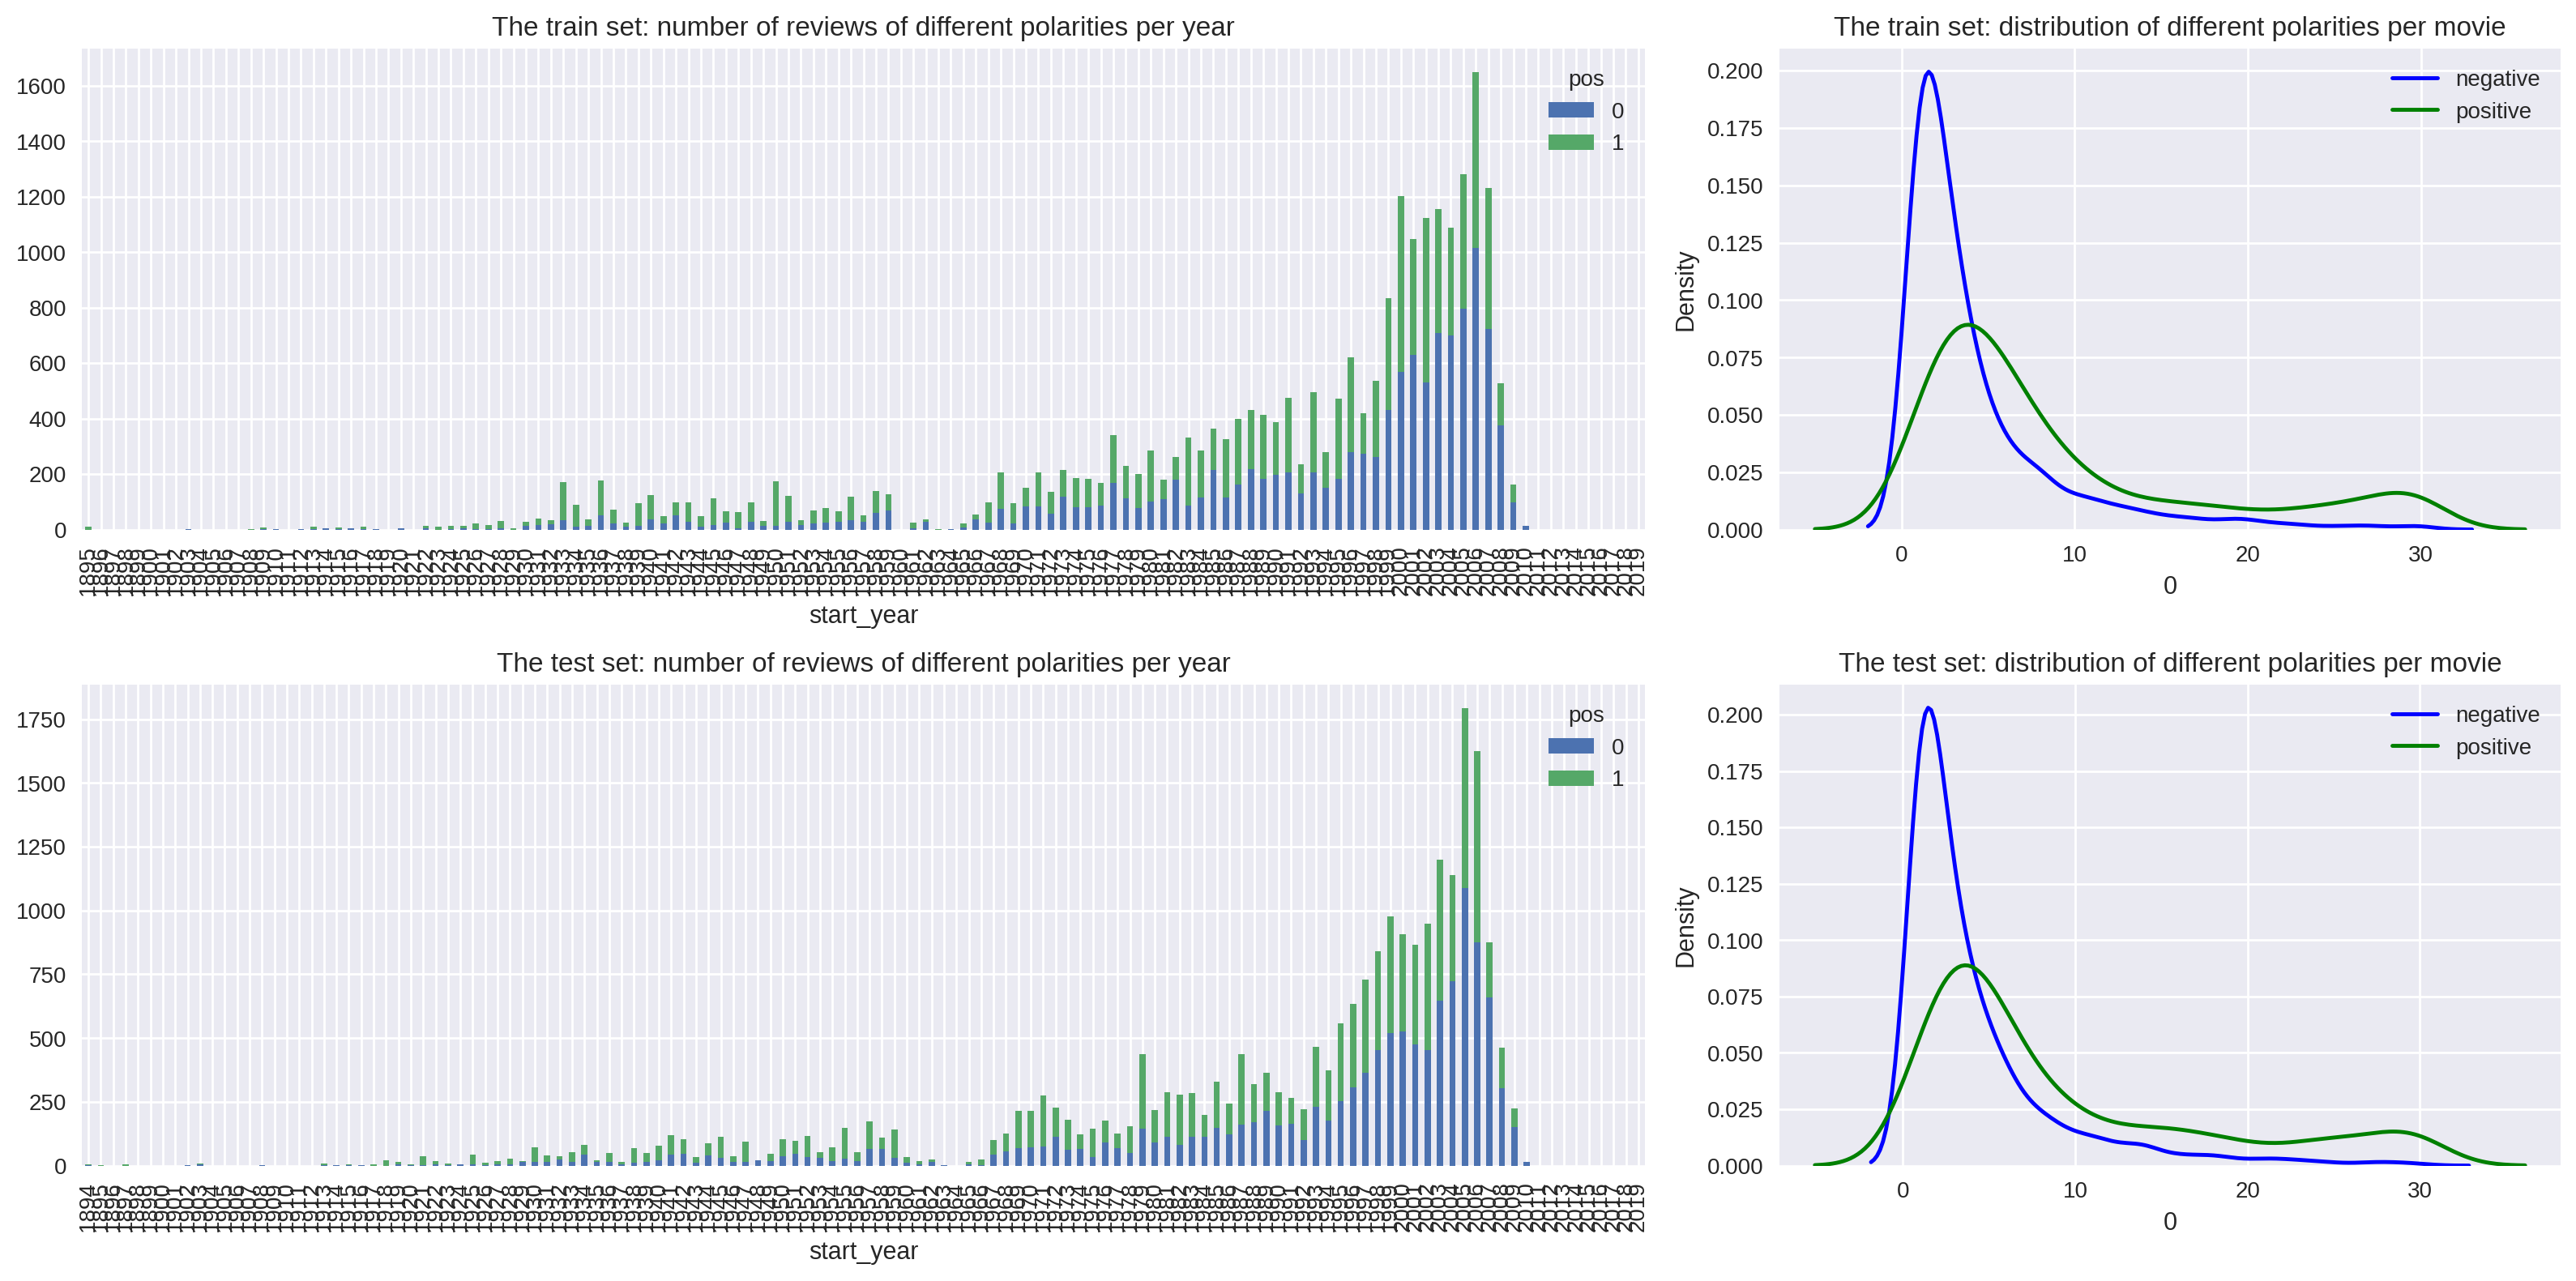

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

**The Train Set: Number of Reviews of Different Localities per Year**  

Trend: The number of reviews has been increasing steadily from 2001 to 2015.  
Significant Jump: There is a noticeable increase in the number of reviews after 2010.  
Categories: The graph shows two categories, labeled ‘0’ (blue) and ‘1’ (green). Both categories follow the overall increasing trend, but the ‘1’ category has a higher number of reviews in most years.  

**The Test Set: Number of Reviews of Different Localities per Year**  

Trend: Similar to the train set, the number of reviews in the test set also shows an increasing trend from 2001 to 2015.  
Fewer Reviews: The test set has fewer overall reviews compared to the train set.  
Categories: The same two categories (‘0’ in blue and ‘1’ in green) are present, with the ‘1’ category generally having more reviews.  

**The Train & Test Distribution of Different Polarities per Review**  
Density Plots: The graph shows two overlapping density plots for negative (blue) and positive (green) polarities.  
Peak Around Zero: Both distributions peak around zero, indicating that most reviews are centered around a neutral sentiment.  
Spread and Symmetry: The negative and positive distributions differ slightly in their spread and symmetry, with the positive distribution being slightly more spread out.  

**Summary**
Increasing Trend: Both the train and test sets show an increasing trend in the number of reviews over the years, with a significant jump after 2010.  
Category Distribution: The ‘1’ category consistently has more reviews than the ‘0’ category in both sets.  
Sentiment Analysis: The sentiment distribution shows that most reviews are neutral, with slight differences in the spread of negative and positive reviews.  

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
def process_txt(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}0-9]", '', text)
    return text

In [13]:
df_reviews['review_norm'] = df_reviews['review'].apply(process_txt)

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [14]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

X_train = df_reviews_train['review_norm']
y_train = df_reviews_train['pos']

X_test = df_reviews_test['review_norm']
y_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23796, 18)
(23535, 18)
(23796,)
(23796,)
(23535,)
(23535,)


## Working with models

### Model 0 - Constant

In [15]:
model_0 = DummyClassifier(strategy="stratified",random_state=12345)
model_0.fit(X_train, y_train)


DummyClassifier(random_state=12345, strategy='stratified')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


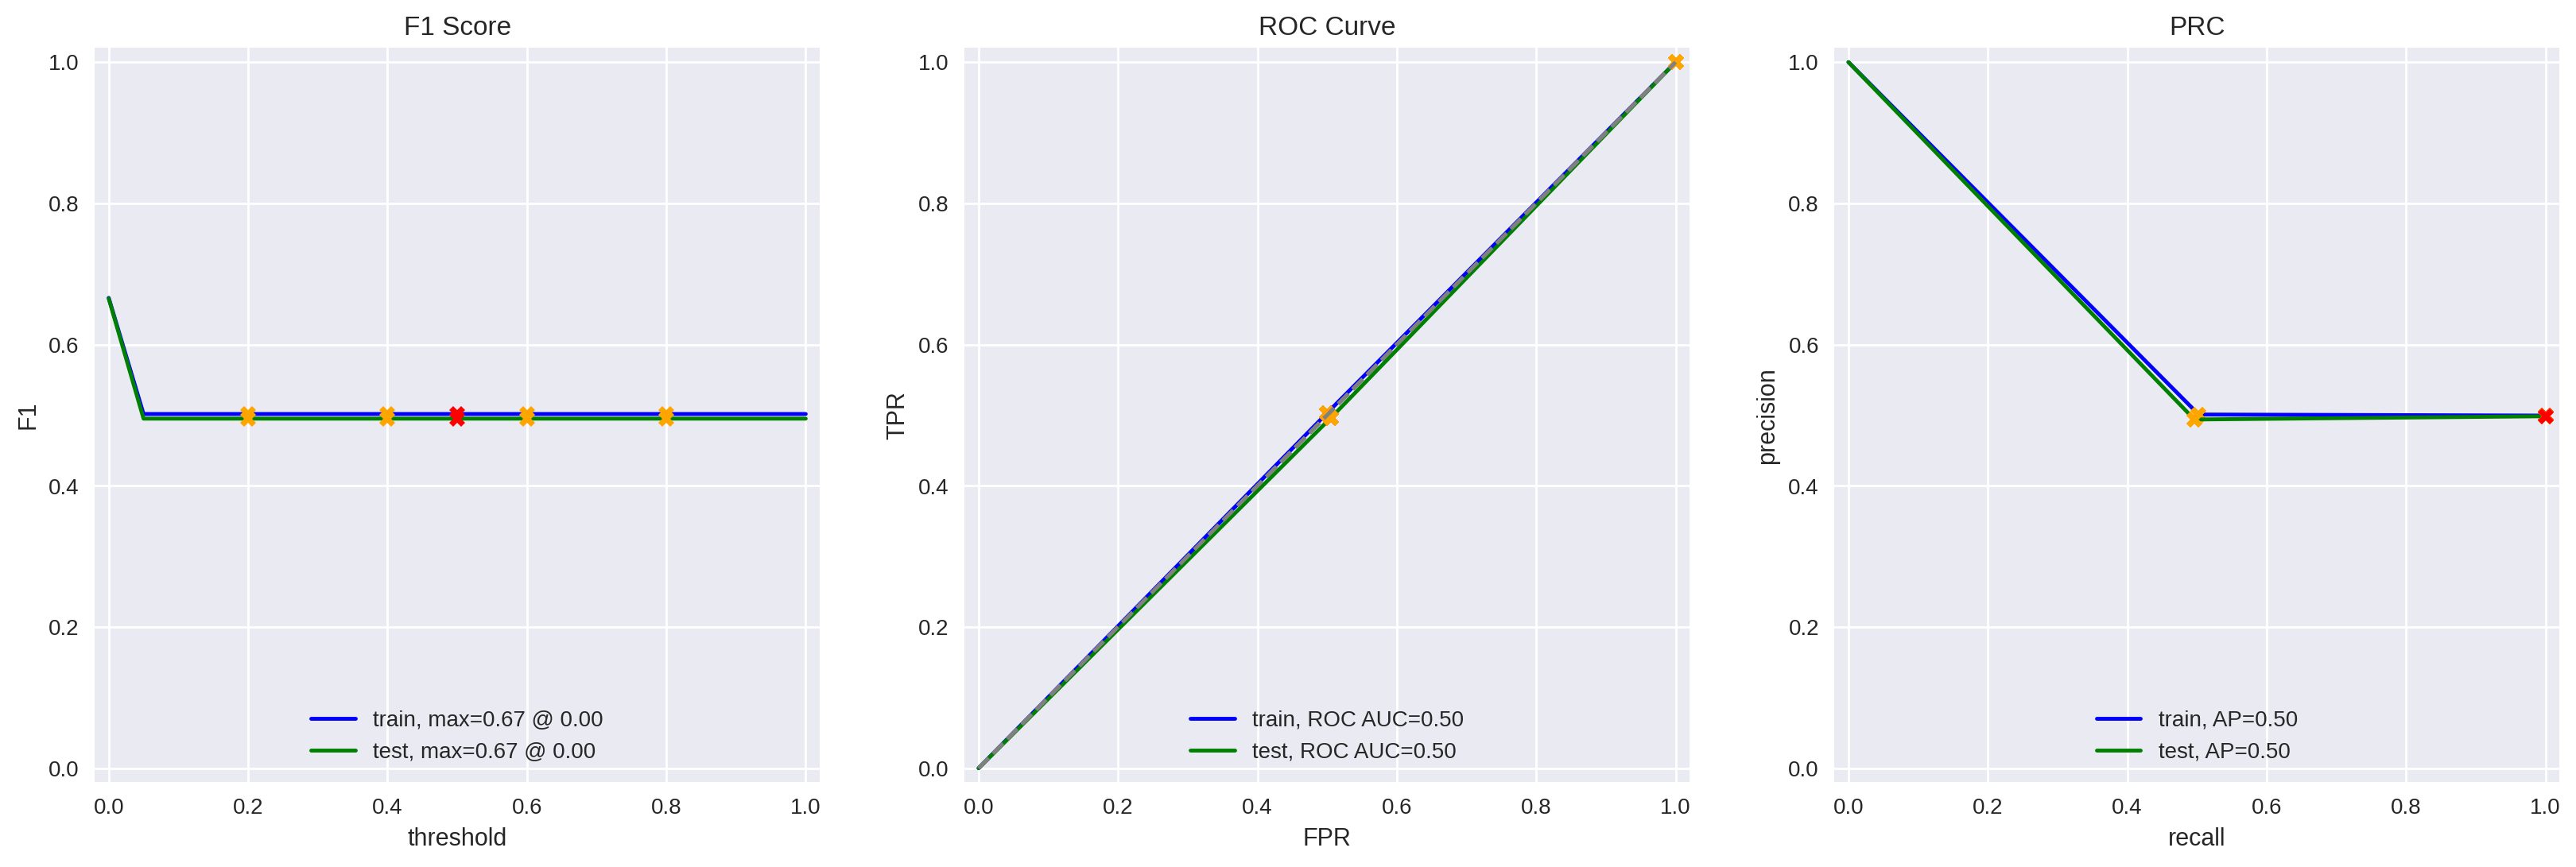

In [16]:
evaluate_model(model_0, X_train, y_train, X_test, y_test)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [17]:
stopwords = set(stopwords.words('english'))
vectorizer_lr = TfidfVectorizer(stop_words=stopwords)
train_lr = vectorizer_lr.fit_transform(X_train)
test_lr = vectorizer_lr.transform(X_test)

**Logistic Regression**

In [18]:
model_lr = LogisticRegression()
model_lr.fit(train_lr, y_train)


LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


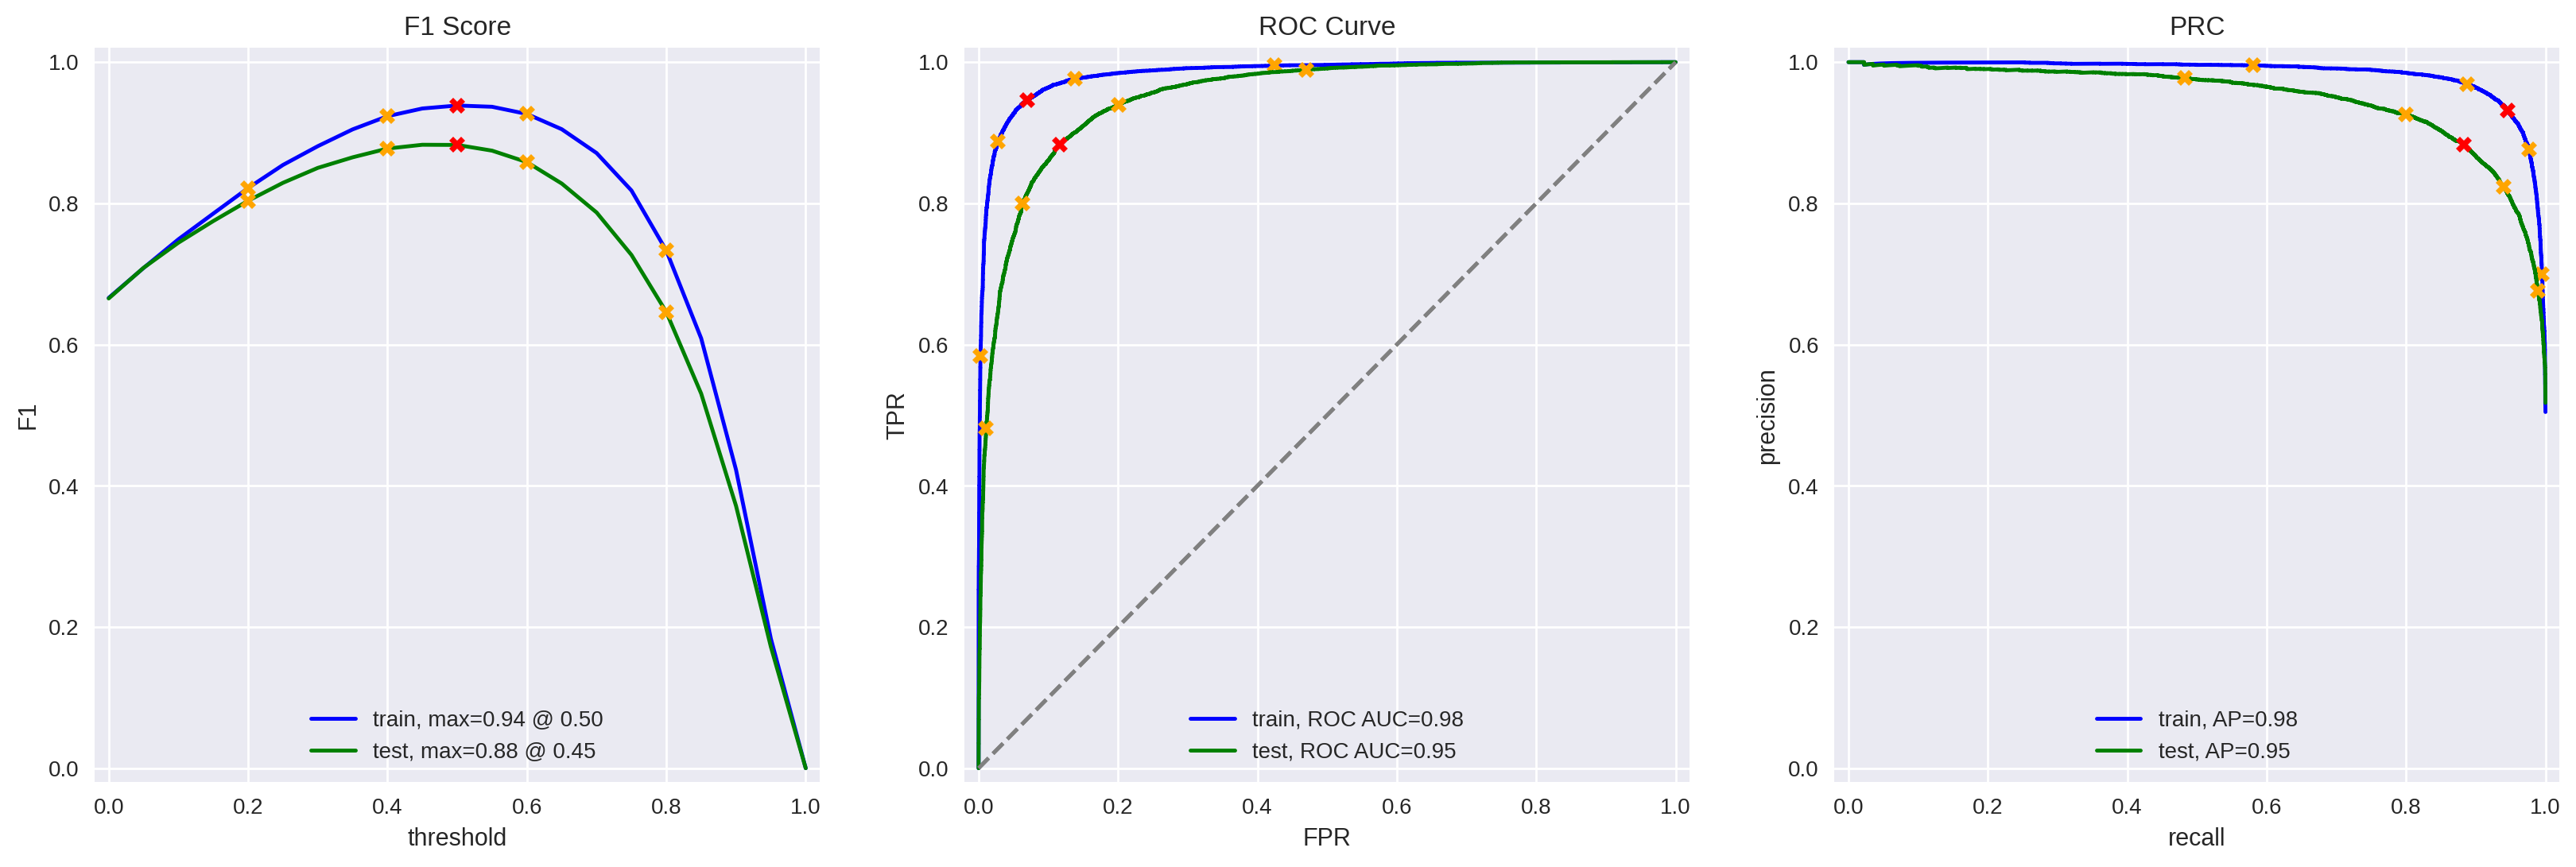

In [19]:
evaluate_model(model_lr, train_lr, train_target, test_lr, test_target)

**Decision Tree**

In [44]:
model_dr = DecisionTreeClassifier(random_state=12345, class_weight='balanced')
model_dr.fit(train_lr, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=12345)

          train  test
Accuracy    1.0  0.70
F1          1.0  0.70
APS         1.0  0.64
ROC AUC     1.0  0.70


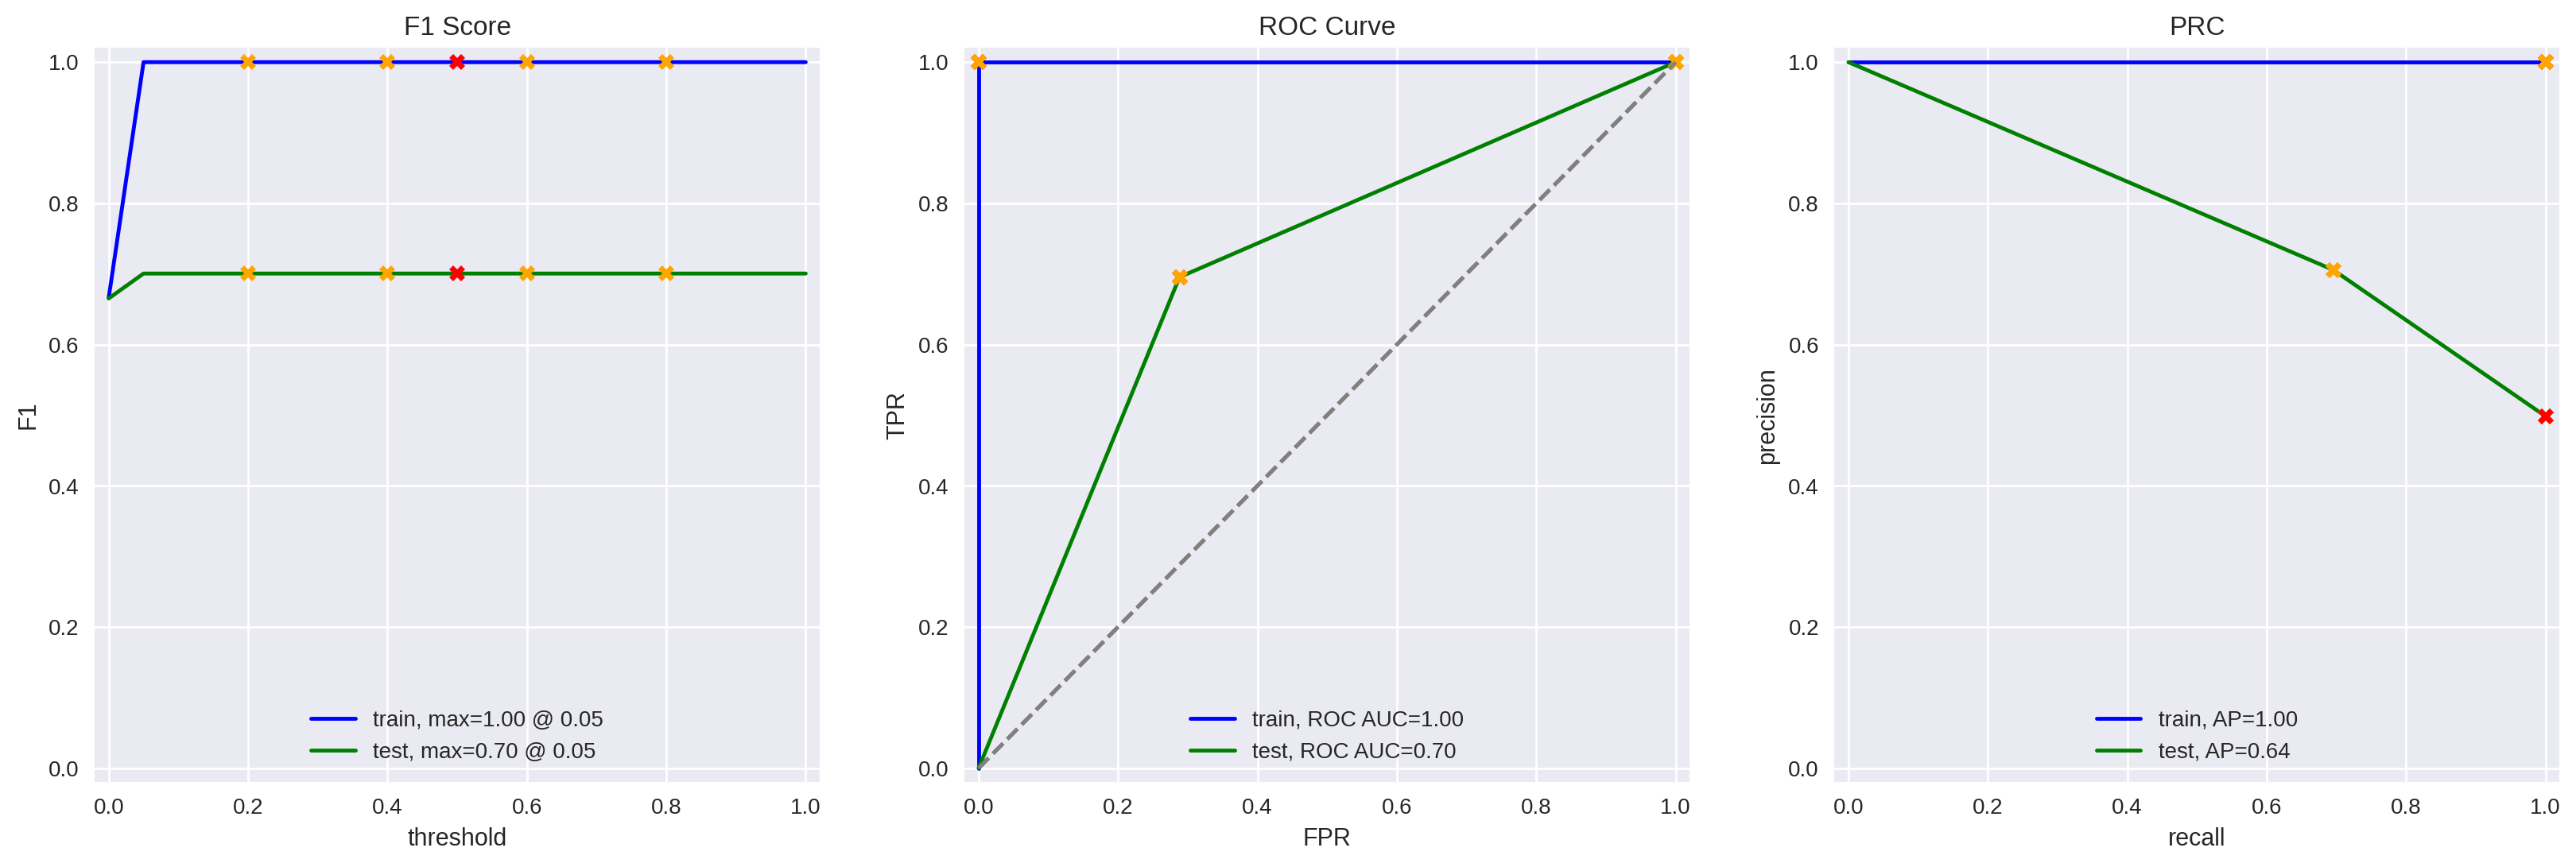

In [52]:
evaluate_model(model_dr, train_lr, train_target, test_lr, test_target)

**Random Forest Classifier**

In [47]:
model_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')
model_rf.fit(train_lr, y_train)

RandomForestClassifier(class_weight='balanced', random_state=12345)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.83
APS         1.0  0.90
ROC AUC     1.0  0.91


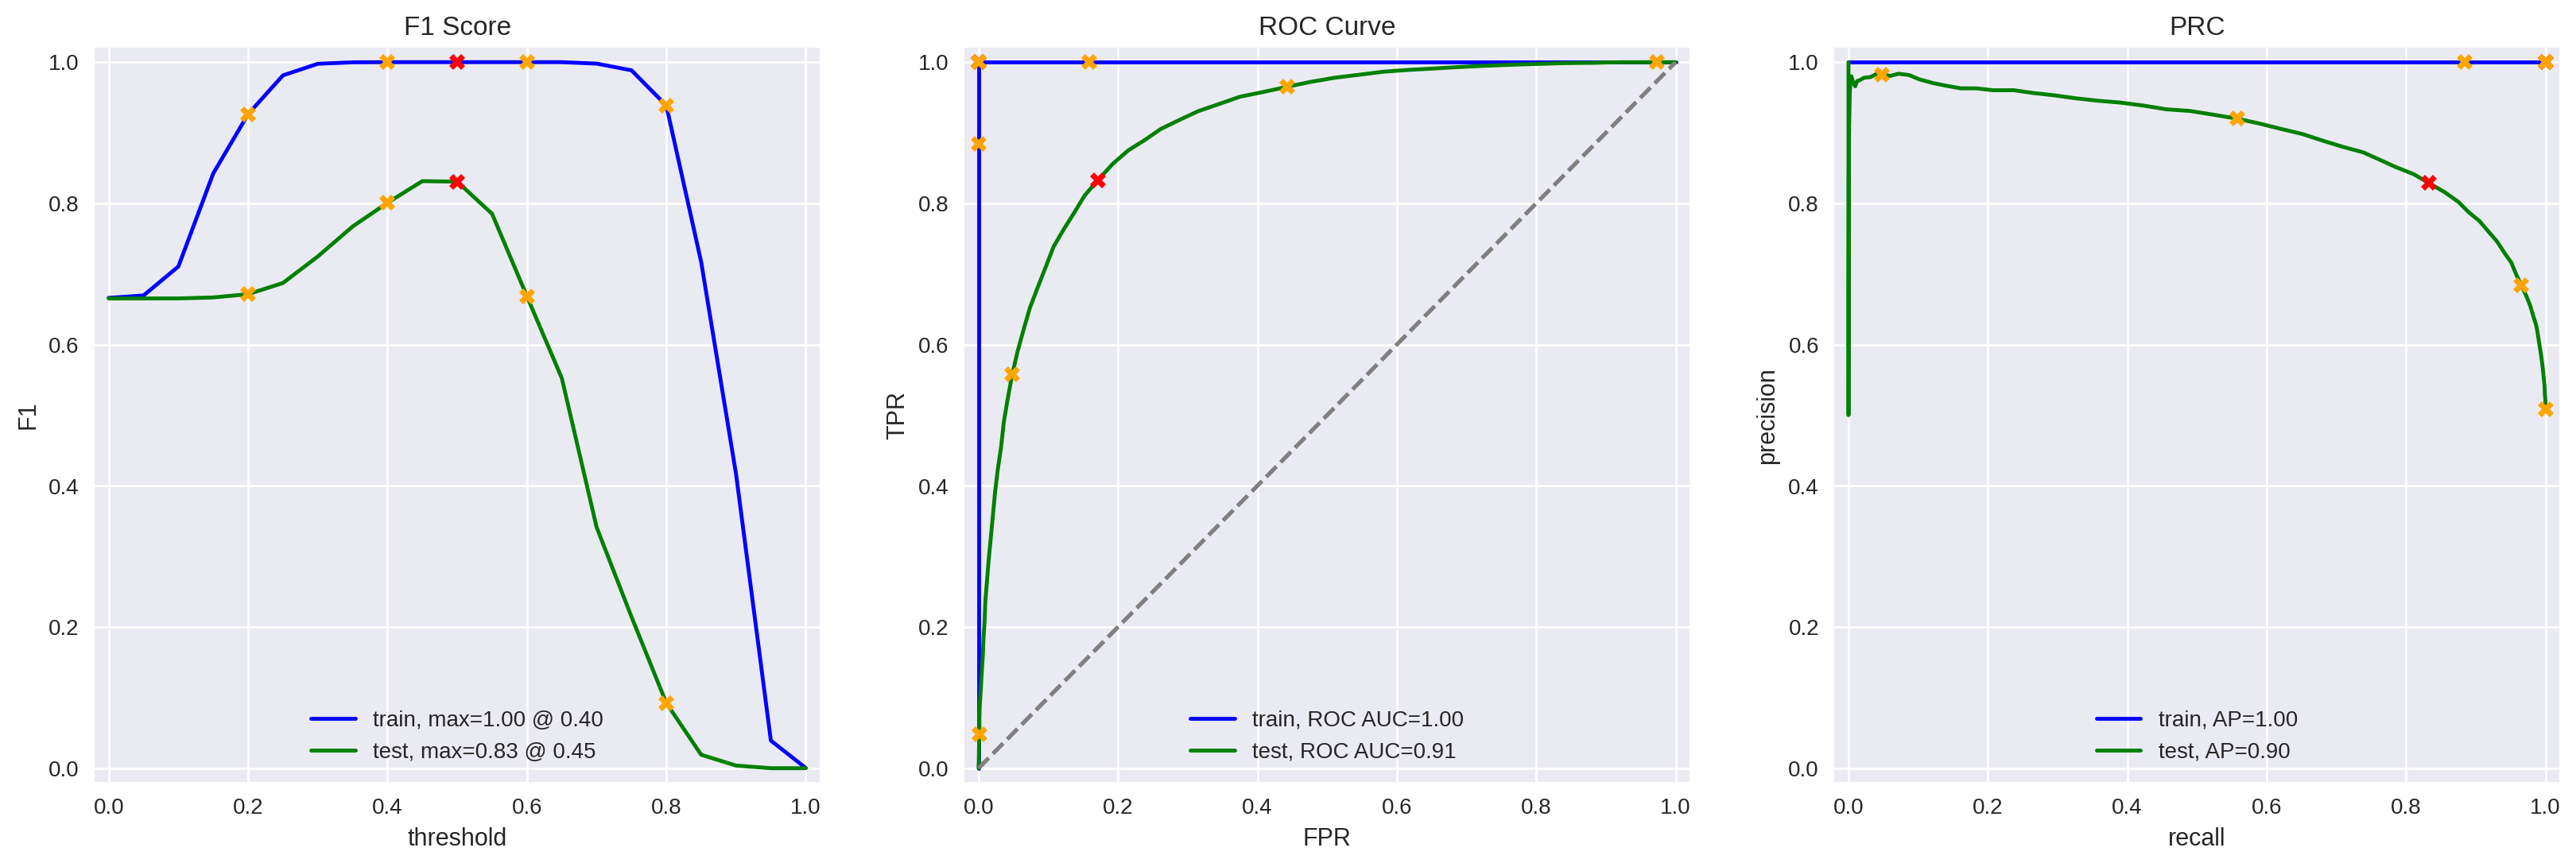

In [53]:
evaluate_model(model_rf, train_lr, train_target, test_lr, test_target)

Random Forest

### Model 2 - spaCy, TF-IDF and LR

In [22]:
lemmatizer = WordNetLemmatizer()

In [23]:
def lemmatize_text(text):
    tokens = word_tokenize(str(text).lower())
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized = ' '.join(lemmas)
    return lemmatized

In [24]:
X_train_lem = X_train.apply(lemmatize_text)
X_test_lem = X_test.apply(lemmatize_text)

In [25]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [26]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

**Logistic Regression**

In [27]:
X_train_spacy = X_train.progress_apply(lambda x: text_preprocessing_3(x))
X_test_spacy = X_test.progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [28]:
vect_space = TfidfVectorizer(stop_words=stopwords)
X_train_spacy_ = vect_space.fit_transform(X_train_spacy)
X_test_spacy_ = vect_space.transform(X_test_spacy)

model_lr_space = LogisticRegression()
model_lr_space.fit(X_train_spacy_, y_train)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


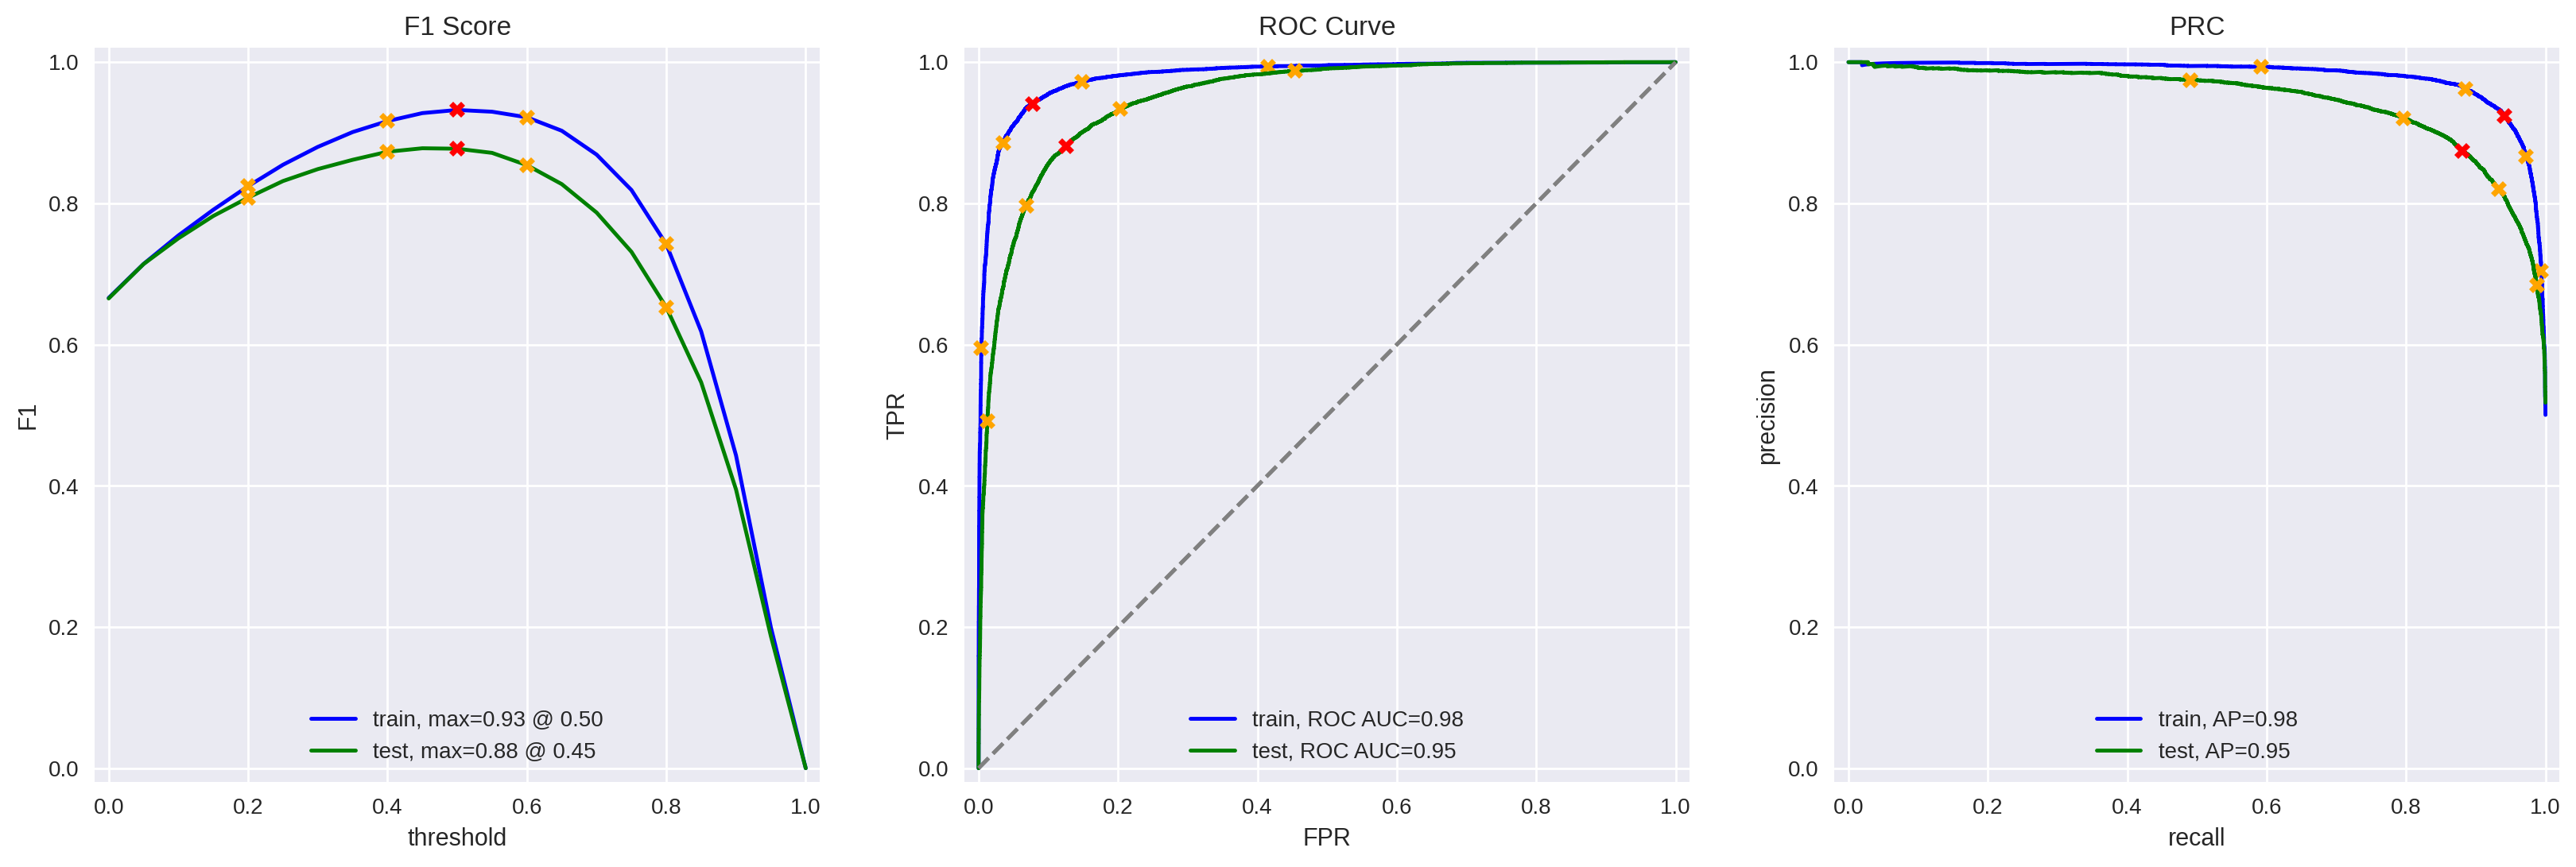

In [29]:
evaluate_model(model_lr_space, X_train_spacy_, y_train, X_test_spacy_, y_test)

---

**Decision Tree Classifier**

In [63]:
model_dr_space = DecisionTreeClassifier(class_weight='balanced', random_state=12345)
model_dr_space.fit(X_train_spacy_, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=12345)

          train  test
Accuracy    1.0  0.71
F1          1.0  0.71
APS         1.0  0.65
ROC AUC     1.0  0.71


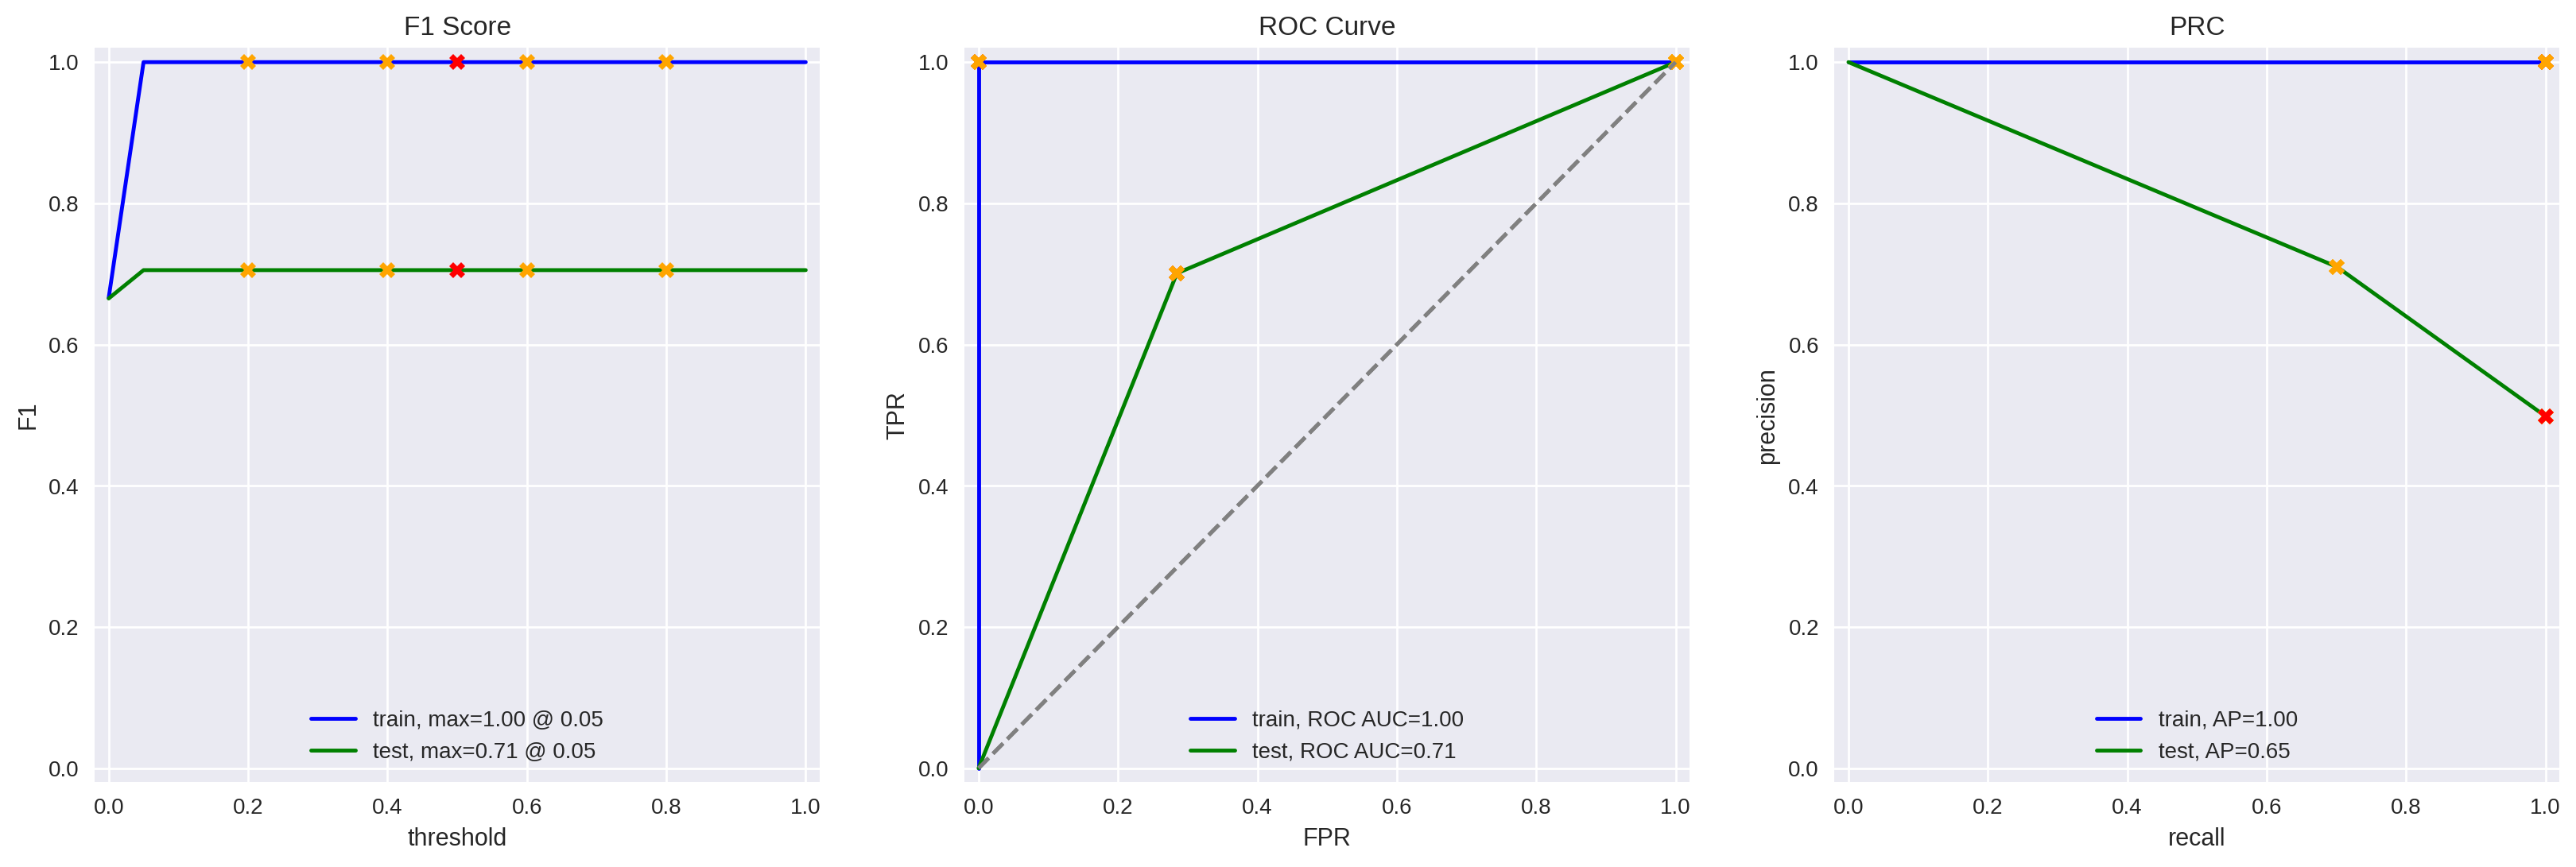

In [64]:
evaluate_model(model_dr_space, X_train_spacy_, y_train, X_test_spacy_, y_test)

**Random Forest Classifier**

In [66]:
model_rf_space = RandomForestClassifier(random_state=12354, class_weight='balanced')
model_rf_space.fit(X_train_spacy_, y_train)

RandomForestClassifier(class_weight='balanced', random_state=12354)

          train  test
Accuracy    1.0  0.83
F1          1.0  0.83
APS         1.0  0.90
ROC AUC     1.0  0.91


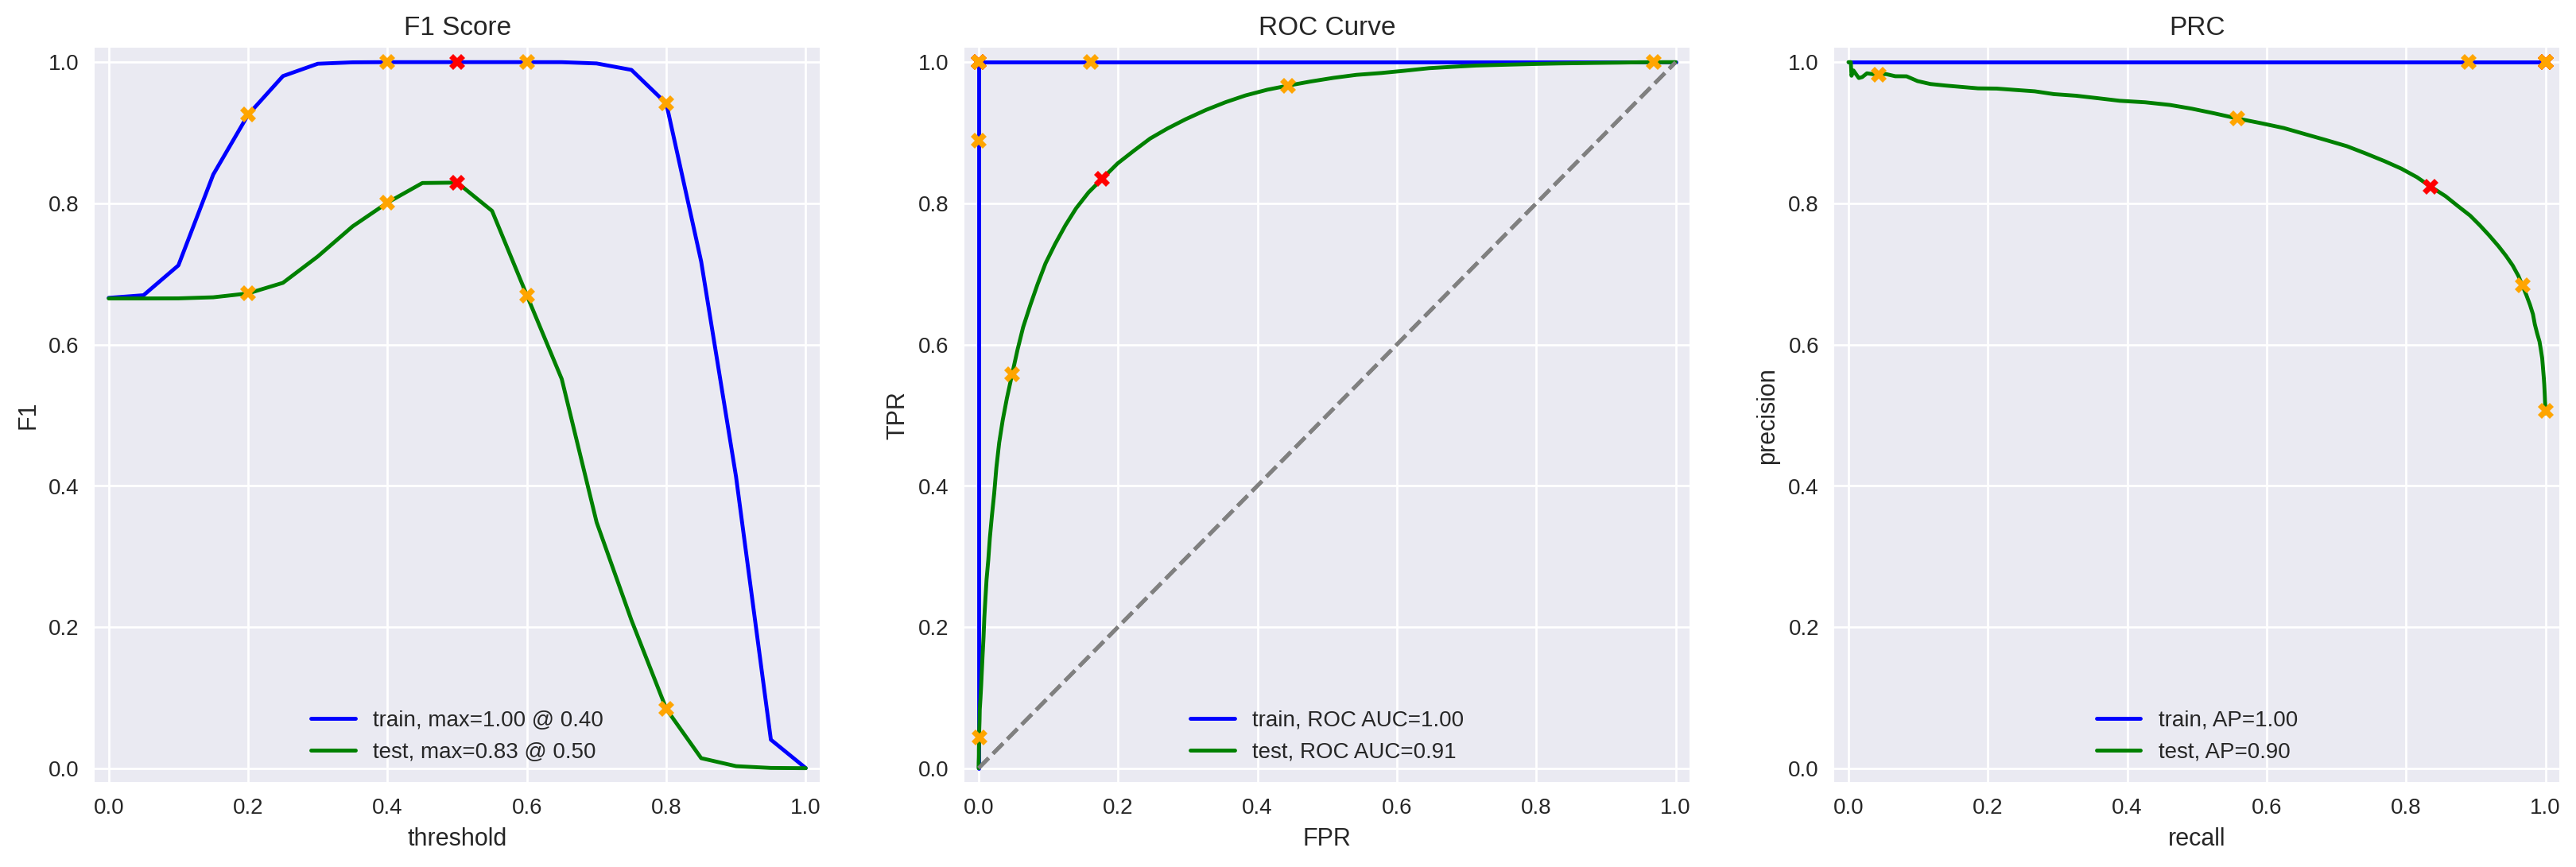

In [67]:
evaluate_model(model_rf_space, X_train_spacy_, y_train, X_test_spacy_, y_test)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [68]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X_train_spacy_, y_train)

LGBMClassifier()

          train  test
Accuracy   0.92  0.86
F1         0.92  0.86
APS        0.98  0.93
ROC AUC    0.98  0.94


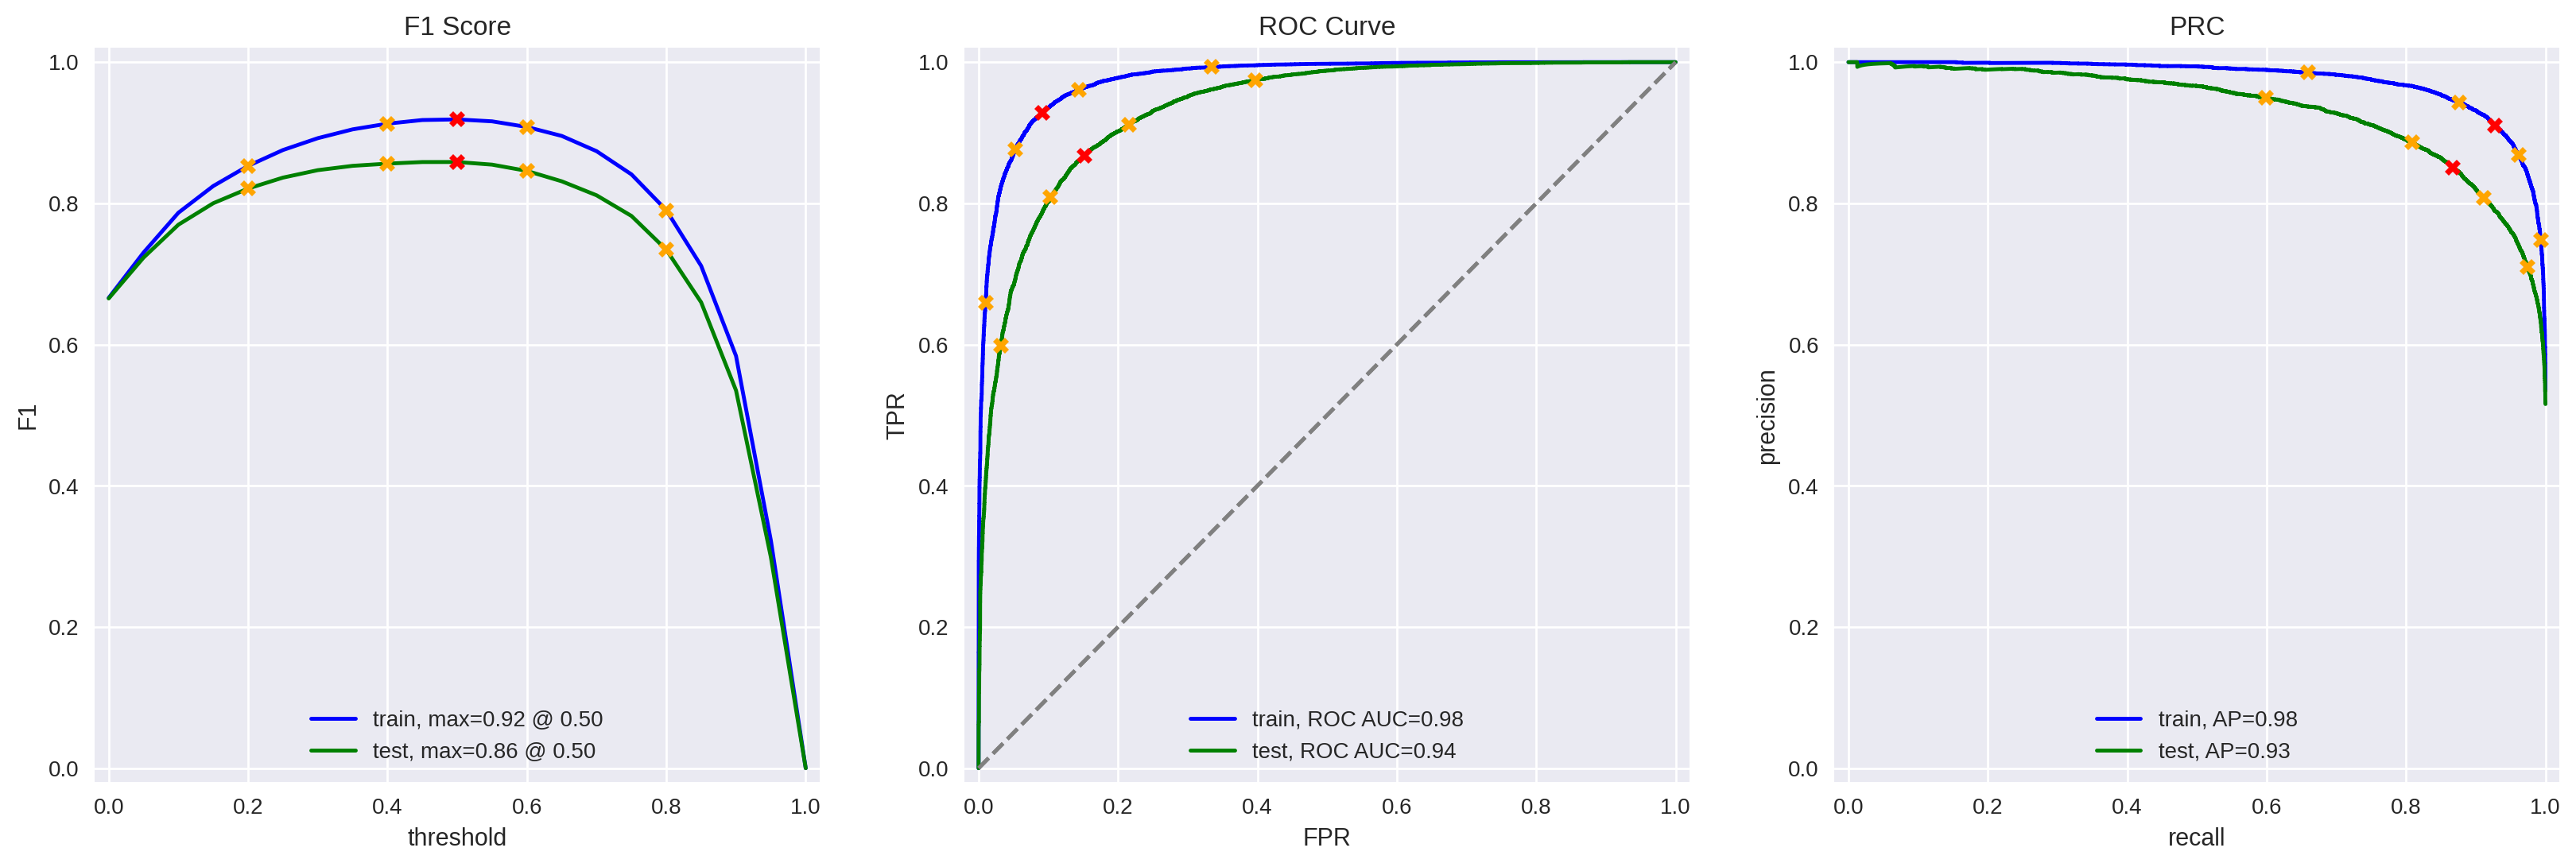

In [69]:
evaluate_model(model_lgbm, X_train_spacy_, y_train, X_test_spacy_, y_test)

---

## My Reviews

In [73]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(process_txt)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 2

**Logistic Regression**

In [74]:
texts = my_reviews['review_norm']
my_features = vectorizer_lr.transform(texts)

my_reviews_pred_prob = model_lr.predict_proba(my_features)[:, 1]
my_reviews_pred = model_lr.predict(my_features)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}  {my_reviews_pred[i]}:  {review}')

0.15  0:  i did not simply like it not my kind of movie
0.31  0:  well i was bored and felt asleep in the middle of the movie
0.59  1:  i was really fascinated with the movie
0.23  0:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.25  0:  i didnt expect the reboot to be so good writers really cared about the source material
0.60  1:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.07  0:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83  1:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

**Logistic Regression - Spacy**

In [75]:
my_features_space = vect_space.transform(texts)
prob_space = model_lr_space.predict_proba(my_features_space)[:, 1]
pred_space = model_lr_space.predict(my_features_space)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{prob_space[i]:.2f} {pred_space[i]}:  {review} ')

0.32 0:  i did not simply like it not my kind of movie 
0.23 0:  well i was bored and felt asleep in the middle of the movie 
0.54 1:  i was really fascinated with the movie 
0.41 0:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul 
0.45 0:  i didnt expect the reboot to be so good writers really cared about the source material 
0.71 1:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel 
0.07 0:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids  
0.90 1:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis 


### Model 4

**LGBM Classifier - Spacy**

In [76]:
prob_lgbm = model_lgbm.predict_proba(my_features_space)[:, 1]
pred_space = model_lgbm.predict(my_features_space)

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{prob_space[i]:.2f} {pred_space[i]}:  {review} ')

0.32 1:  i did not simply like it not my kind of movie 
0.23 1:  well i was bored and felt asleep in the middle of the movie 
0.54 1:  i was really fascinated with the movie 
0.41 1:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul 
0.45 1:  i didnt expect the reboot to be so good writers really cared about the source material 
0.71 1:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel 
0.07 0:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids  
0.90 1:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis 


## Conclusions

**The Logistic Regression** model demonstrates strong performance on both the training and test sets, with the following metrics:

Accuracy: 0.93 (train), 0.88 (test)  
F1 Score: 0.93 (train), 0.88 (test)  
Average Precision Score (APS): 0.98 (train), 0.95 (test)  
ROC AUC: 0.98 (train), 0.95 (test)  
These metrics indicate that the model is well-calibrated and generalizes well to unseen data, as there is no significant drop in performance from the training to the test set.  

Predictions on Reviews  
When applied to the review texts, the model’s predicted probabilities and classifications align with the sentiment expressed in the reviews. For example:  

Reviews with negative sentiment (e.g., “i did not simply like it not my kind of movie”) have low predicted probabilities (e.g., 0.15) and are classified as negative (0).
Reviews with positive sentiment (e.g., “i was really fascinated with the movie”) have higher predicted probabilities (e.g., 0.59) and are classified as positive (1).


Overall, the Logistic Regression model is performing well in terms of both classification metrics and practical application to review texts. The high APS and ROC AUC scores suggest that the model is effective at distinguishing between positive and negative sentiments. Additionally, the consistency between predicted probabilities and actual sentiments in the reviews indicates that the model’s predictions are reliable.

---

**The Logistic regression** model trained with TF-IDF vectorized features shows strong performance on both the training and test sets:

Accuracy: 0.93 (train), 0.88 (test)  
F1 Score: 0.93 (train), 0.88 (test)  
Average Precision Score (APS): 0.98 (train), 0.95 (test)  
ROC AUC: 0.98 (train), 0.95 (test)  
These metrics indicate that the model generalizes well from the training data to the test data, maintaining high precision and recall.  

Predictions on New Texts  
The model’s predictions on new texts show a range of probabilities and corresponding classifications:  

Negative Reviews: The model correctly identifies negative reviews with low probabilities (e.g., 0.32, 0.23, 0.07).  
Positive Reviews: The model also correctly identifies positive reviews with higher probabilities (e.g., 0.54, 0.71, 0.90).  
Conclusion  
The logistic regression model with TF-IDF vectorization is effective in classifying text data. It demonstrates high accuracy, precision, and recall on both training and test sets, and it performs well on new, unseen texts. The model’s ability to assign appropriate probabilities to the reviews further supports its reliability.  

---

**The LightGBM model** demonstrates strong performance on both the training and test sets: 
Accuracy 0.92 on train, 0.86 on test  
F1 scores 0.92 on train, 0.86 on test  
Average Precision Score APS: 0.98 on train, 0.93 on test  
ROC AUC: 0.98 on train, 0.94 on test  
This suggestion that the model is effective at distinguishing between classes and has a good understanding of the underlying data distribution.  

The slight drop in performance from the training set to the test set is expected and indicates that the model generalizes well to unseen data. The difference is not significant, which suggests that the model is not overfitting.  
Comparison with Text Data:  
The provided text data with sentiment scores and labels (0 or 1) can be used to further evaluate the model’s performance in a real-world scenario. The model’s ability to correctly classify these sentiments would be a good indicator of its practical utility.  
Given the high evaluation metrics, the model is likely to perform well on this text data, accurately predicting the sentiment labels based on the provided scores.  
In conclusion, the LightGBM model exhibits strong performance and generalization capabilities, making it a reliable choice for classification tasks. Its high accuracy, F1 score, APS, and ROC AUC on both training and test sets indicate that it is well-suited for real-world applications, including sentiment analysis of text data.  